In [2]:
import sys
sys.path.append("..") 
from utils import coefs, parameterize, helpers

In [57]:
import cv2
from imageio import imread
d = "/mnt/c/Users/trang.le/Desktop/2D_shape_space/U2OS_2"
img_id = '757_50_D9_1_3'#'30222_1650_F1_8_17'#"29524_1773_F11_6_3"#"2485_35_F10_1_7" #29433_1055_D8_1_11
protein = imread(f"{d}/{img_id}_protein.png")
shape = imread(f"{d}/{img_id}.png")

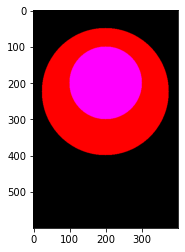

In [37]:
import numpy as np
from skimage.morphology import disk, square, dilation
import matplotlib.pyplot as plt 

height, width = 600, 400
#centroid = (, width//2)
target_nu = np.zeros((height, width), dtype=np.uint8)
target_nu[100:301,100:301] = disk(100)
target_cell = np.zeros((height, width), dtype=np.uint8)
target_cell[49:400, 24:375] = disk(175)
#target_cell[50:351,50:351] = disk(150)
avg_cell = np.dstack([target_cell, np.zeros((height,width)),target_nu])
plt.imshow(avg_cell)

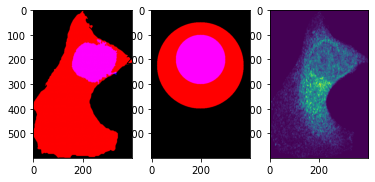

In [59]:
#shape = np.rotate(shape,90)
from skimage.transform import rescale, resize
fig,ax = plt.subplots(1,3)
#ax[0].imshow(resize(shape, (600,400)))
ax[0].imshow(resize(np.rot90(shape,3), (600,400)))
ax[1].imshow(avg_cell)#elastic_transform(shape,8,0.5))
ax[2].imshow(resize(np.rot90(protein,3), (600,400)))
#ax[2].imshow(resize(protein, (600,400)))

In [14]:
from utils.coefs import find_nearest, find_centroid
def realign_contour_startpoint(xy):
    centroid = find_centroid(xy)
    x = np.array([p[0] for p in xy])
    y = np.array([p[1] for p in xy])
    _, val = find_nearest(y[np.where(x > centroid[0])], centroid[1])
    if len(np.where(y == val)[0]) > 1:
        largest_x = x.min()
        current_idx = None
        for idx in np.where(y == val)[0]:
            if x[idx] > largest_x:
                largest_x = x[idx]
                current_idx = idx
        idx = current_idx
    else:
        idx = np.where(y == val)[0][0]

    xy = np.concatenate((xy, xy))[idx : idx + len(xy)]
    return xy

In [60]:
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass, rotate
from skimage.morphology import convex_hull_image

(x_max, y_max,_) = avg_cell.shape
border_anchors = [[0,0],[x_max//2,0],[x_max,0],[0,y_max//2],[0,y_max],[x_max//2,y_max],[x_max,y_max//2],[x_max,y_max]]

ori_shape = resize(np.rot90(shape,3), (600,400)) #resize(shape, (600,400)) #
img = resize(np.rot90(protein,3), (600,400)) #resize(protein, (600,400)) #

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=32)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

convex_hull_nu = convex_hull_image(nu_)
convex_hull_nu_contour = find_contours(convex_hull_nu)
x,y = helpers.equidistance(convex_hull_nu_contour[0][:,0], convex_hull_nu_contour[0][:,1], n_points=32)
convex_hull_nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])


cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=32)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1 = np.vstack([np.array(nu_centroid),
                  realign_contour_startpoint(nu_contour),
                  realign_contour_startpoint(cell_contour), border_anchors])

convex_hull_cell = convex_hull_image(cell_)
convex_hull_cell_contour = find_contours(convex_hull_cell)
if len(convex_hull_cell_contour)>1:
    convex_hull_cell_contour = np.vstack(convex_hull_cell_contour)
    convex_hull_cell_contour = realign_contour_startpoint(convex_hull_cell_contour)
    x,y = helpers.equidistance(convex_hull_cell_contour[:,0], convex_hull_cell_contour[:,1], n_points=32)
else:
    x,y = helpers.equidistance(convex_hull_cell_contour[0][:,0], convex_hull_cell_contour[0][:,1], n_points=32)
convex_hull_cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1_convex = np.vstack([np.array(nu_centroid),
                         realign_contour_startpoint(convex_hull_nu_contour),
                         realign_contour_startpoint(convex_hull_cell_contour), border_anchors])

nu_centroid = center_of_mass(avg_cell[:,:,2]) 
nu_contour = find_contours(avg_cell[:,:,2])
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=32)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_contour = find_contours(avg_cell[:,:,0]) 
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=32)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts2 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])
  

2389


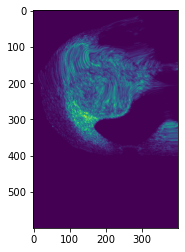

In [66]:
from utils import image_warp
t = image_warp._make_inverse_warp(pts1[:-8], pts2[:-8], (0, 0, 600,400), approximate_grid=1)
warped = cv2.remap(img, t[1].astype('float32'), t[0].astype('float32'),cv2.INTER_LINEAR)
plt.imshow(warped)

Text(0.5, 1.0, 'landmark arrows')

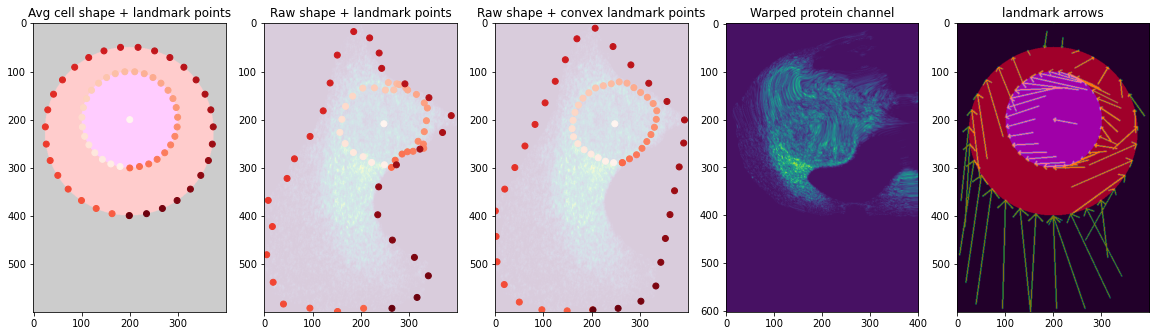

In [62]:

from scipy.ndimage import map_coordinates
warped = map_coordinates(img, t, order=2) 
fig, ax = plt.subplots(1,5, figsize=(20,50))
ax[0].imshow(avg_cell, alpha=0.2)
ax[0].scatter(pts2[:-8][:,1], pts2[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[0].set_title('Avg cell shape + landmark points')
ax[1].imshow(img, alpha=0.2)
ax[1].scatter(pts1[:-8][:,1], pts1[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[1].set_title('Raw shape + landmark points')
ax[2].imshow(img, alpha=0.2)
ax[2].scatter(pts1_convex[:-8][:,1], pts1_convex[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[2].set_title('Raw shape + convex landmark points')
ax[3].imshow(warped)
ax[3].set_title('Warped protein channel')

tmp = img.copy()
line = lambda u,v : cv2.arrowedLine(tmp, (u[1], u[0]), (v[1], v[0]), (255,100,100), 2)
for u,v in zip(pts1, pts2):
    line(np.round(u).astype('int'),np.round(v).astype('int'))

ax[4].imshow(tmp)
ax[4].imshow(avg_cell, alpha=0.5)
ax[4].set_title('landmark arrows')


Text(0.5, 1.0, 'average shape')

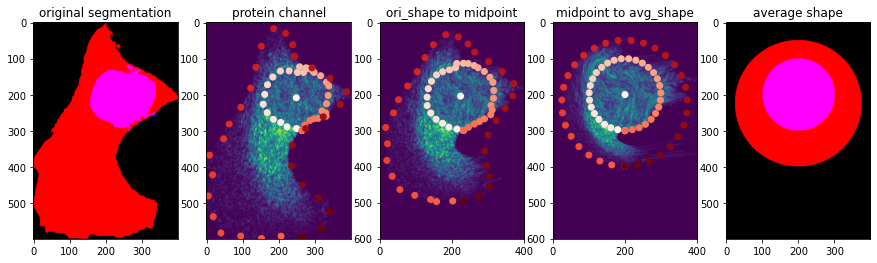

In [69]:
#warped = image_warp.warp_images(pts1, pts2, img, (0, 0, 600, 400), interpolation_order = 1, approximate_grid=2)
midpoint = (pts1 + pts2) /2
transform1 = image_warp._make_inverse_warp(pts1[:-8], midpoint[:-8], (0, 0, 600,400), approximate_grid=4)
transform2 = image_warp._make_inverse_warp(midpoint[:-8], pts2[:-8], (0, 0, 600,400), approximate_grid=4)
warped1 = cv2.remap(img, transform1[1].astype('float32'), transform1[0].astype('float32'),cv2.INTER_LINEAR)
warped = cv2.remap(warped1, transform2[1].astype('float32'), transform2[0].astype('float32'),cv2.INTER_LINEAR)
fig, ax = plt.subplots(1,5, figsize=(15,30))
ax[0].imshow(ori_shape)
ax[0].set_title('original segmentation')
ax[1].imshow(img)
ax[1].scatter(pts1[:-8][:,1], pts1[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[1].set_title('protein channel')
ax[2].imshow(warped1)
ax[2].scatter(midpoint[:-8][:,1], midpoint[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[2].set_title('ori_shape to midpoint')
ax[3].imshow(warped)
ax[3].scatter(pts2[:-8][:,1], pts2[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[3].set_title('midpoint to avg_shape')
ax[4].imshow(avg_cell)
ax[4].set_title('average shape')